In [3]:
import numpy as np
import pandas as pd


import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

In [4]:
df = pd.read_csv('household_power_consumption.txt',
                   parse_dates={'dt' : ['Date', 'Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'],
                   sep=';')

In [5]:
df.fillna(0, inplace=True)
values = df.values

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [7]:
def create_ts_data(dataset, lookback=1, predicted_col=1):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    return final_df

In [8]:
reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)','var1(t)']
display(reframed_df.head(4))

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
id,,,,,,,,
1,0.379069,0.300719,0.924021,0.380165,0.0,0.0125,0.548387,0.481928
2,0.481928,0.313669,0.919260,0.475207,0.0,0.0125,0.516129,0.483186
3,0.483186,0.358273,0.917922,0.475207,0.0,0.0250,0.548387,0.484445
4,0.484445,0.361151,0.919693,0.475207,0.0,0.0125,0.548387,0.329617


In [9]:
reframed_df.isna().sum()

var1(t-1)    0
var2(t-1)    0
var3(t-1)    0
var4(t-1)    0
var5(t-1)    0
var6(t-1)    0
var7(t-1)    0
var1(t)      0
dtype: int64

In [10]:
y=reframed_df['var1(t)']
X=reframed_df.drop(['var1(t)'], axis=1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (1660206, 7)
y_train.shape:  (1660206,)
X_test.shape:  (415052, 7)
y_test.shape:  (415052,)


In [13]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1660206, 1, 7) (1660206,) (415052, 1, 7) (415052,)


## Model LSTM

In [14]:
lstm_model = Sequential()

lstm_model.add(LSTM(75, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(units=30, return_sequences=True))
lstm_model.add(LSTM(units=30))
lstm_model.add(Dense(units=1))

lstm_model.compile(loss='mae', optimizer='adam')

In [15]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 75)             24900     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 30)             12720     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 44,971
Trainable params: 44,971
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=10, 
                              batch_size=64, validation_data=(X_test, y_test),  shuffle=False)

Epoch 1/10
25941/25941 [==============================] - 57s 2ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 2/10
25941/25941 [==============================] - 49s 2ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 3/10
25941/25941 [==============================] - 49s 2ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/10
25941/25941 [==============================] - 49s 2ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 5/10
25941/25941 [==============================] - 48s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 6/10
25941/25941 [==============================] - 49s 2ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 7/10
25941/25941 [==============================] - 55s 2ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/10
25941/25941 [==============================] - 56s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/10
25941/25941 [==============================] - 60s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 10/10
25941/25941 [==============================

# Model GRU

In [17]:
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')

In [18]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 75)             18900     
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 30)             9630      
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 34,141
Trainable params: 34,141
Non-trainable params: 0
_________________________________________________________________


In [19]:
gru_history = model_gru.fit(X_train, y_train, 
                            epochs=10, batch_size=64, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
25941/25941 [==============================] - 57s 2ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 2/10
25941/25941 [==============================] - 57s 2ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 3/10
25941/25941 [==============================] - 56s 2ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 4/10
25941/25941 [==============================] - 56s 2ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
25941/25941 [==============================] - 56s 2ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 6/10
25941/25941 [==============================] - 56s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 7/10
25941/25941 [==============================] - 57s 2ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 8/10
25941/25941 [==============================] - 57s 2ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 9/10
25941/25941 [==============================] - 58s 2ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/10
25941/25941 [==============================

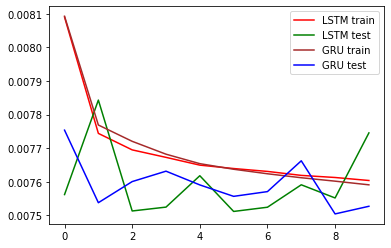

In [20]:
pyplot.plot(history_lstm.history['loss'], label='LSTM train', color='red')
pyplot.plot(history_lstm.history['val_loss'], label='LSTM test', color= 'green')
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
pyplot.legend()
pyplot.show()

# Wybór modelu - GRU 

In [21]:
# Predictions with GRU model

# make a prediction
yhat_test = model_gru.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], 7))

# invert scaling for forecast
print(yhat_test.shape, X_test.shape)
inv_yhat_test = np.concatenate((yhat_test, X_test[:, -6:]), axis=1)
print(inv_yhat_test.shape)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]

(415052, 1) (415052, 7)
(415052, 7)


In [22]:
y_test = y_test.values.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.265


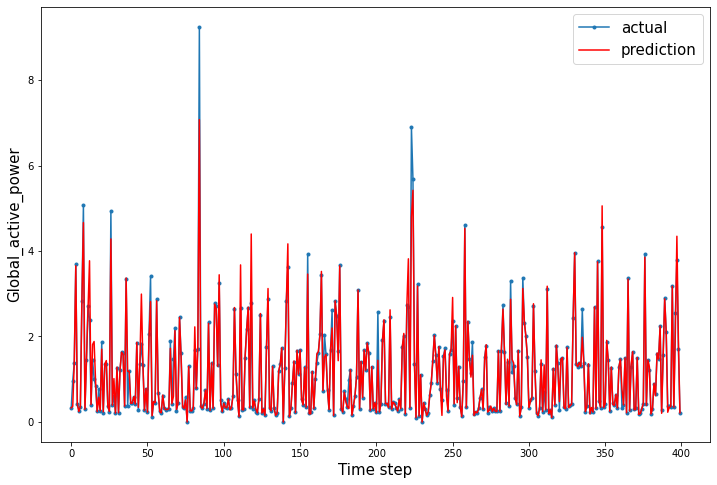

In [23]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(400)]
pyplot.plot(aa, inv_y[:400], marker='.', label="actual")
pyplot.plot(aa, inv_yhat_test[:400], 'r', label="prediction")
pyplot.ylabel('Global_active_power', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)
pyplot.show()

## Modelowanie na zagregowanych danych - uśrednione wartości cotygodniowe

In [49]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates= {'Datetime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])

In [50]:
df.fillna(0, inplace=True)
values = df.values

In [51]:
df = df.set_index('Datetime')
week_df = df.bfill().resample('W').mean()

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)

In [53]:
y=reframed_df['var1(t)']
X=reframed_df.drop(['var1(t)'], axis=1)

In [54]:
reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)','var1(t)']
display(reframed_df.head(4))

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
id,,,,,,,,
1,1.000000,0.516729,0.386506,1.000000,0.432083,0.831182,0.800781,0.667697
2,0.667697,0.339625,0.562735,0.660819,0.433184,0.680646,0.595367,0.764822
3,0.764822,0.530921,0.607750,0.752814,0.554003,0.723948,0.503858,0.560144
4,0.560144,0.458983,0.525333,0.550741,0.226734,0.558764,0.386252,0.612220


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
# Predictions with GRU model

# make a prediction
yhat_test = model_gru.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], 7))

# invert scaling for forecast
print(yhat_test.shape, X_test.shape)
inv_yhat_test = np.concatenate((yhat_test, X_test[:, -6:]), axis=1)
print(inv_yhat_test.shape)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]

(415052, 1) (415052, 7)
(415052, 7)


In [56]:
y_test = y_test.values.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.055


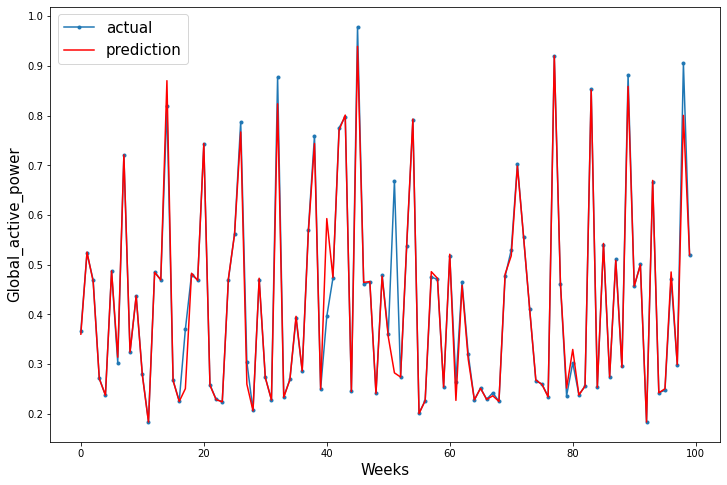

In [59]:
pyplot.figure(figsize=(12,8))
aa=[x for x in range(100)]
pyplot.plot(aa, inv_y[:100], marker='.', label="actual")
pyplot.plot(aa, inv_yhat_test[:100], 'r', label="prediction")
pyplot.ylabel('Global_active_power', size=15)
pyplot.xlabel('Weeks', size=15)
pyplot.legend(fontsize=15)
pyplot.show()